In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.preprocessing import StandardScaler

from reader.reader import read_csv
from mcda.uta import Criterion
from mcda.report import calculate_heuristics
from methods.autoencoder import AutoencoderModel

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df, _ = read_csv("data/s2.csv")
df.head()

,g1,g2,g3,g4,g5
a01,-18342.0,-30.7,-37.2,2.33,3.00
a02,-15335.0,-30.2,-41.6,2.00,2.50
a03,-16973.0,-29.0,-34.9,2.66,2.50
a04,-15460.0,-30.4,-35.8,1.66,1.50
a05,-15131.0,-29.7,-35.6,1.66,1.75


In [3]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [4]:
methods = {
    "PCA": PCA(n_components=2, random_state=42),
    "Autoencoder": AutoencoderModel(encoded_dim=2, epochs=300, batch_size=16),
    "KernelPCA": KernelPCA(n_components=2, random_state=42),
    "t-SNE": TSNE(n_components=2, perplexity=10, method="exact", random_state=42),
    "MDS": MDS(n_components=2, random_state=42),
    "Isomap": Isomap(n_components=2),
}

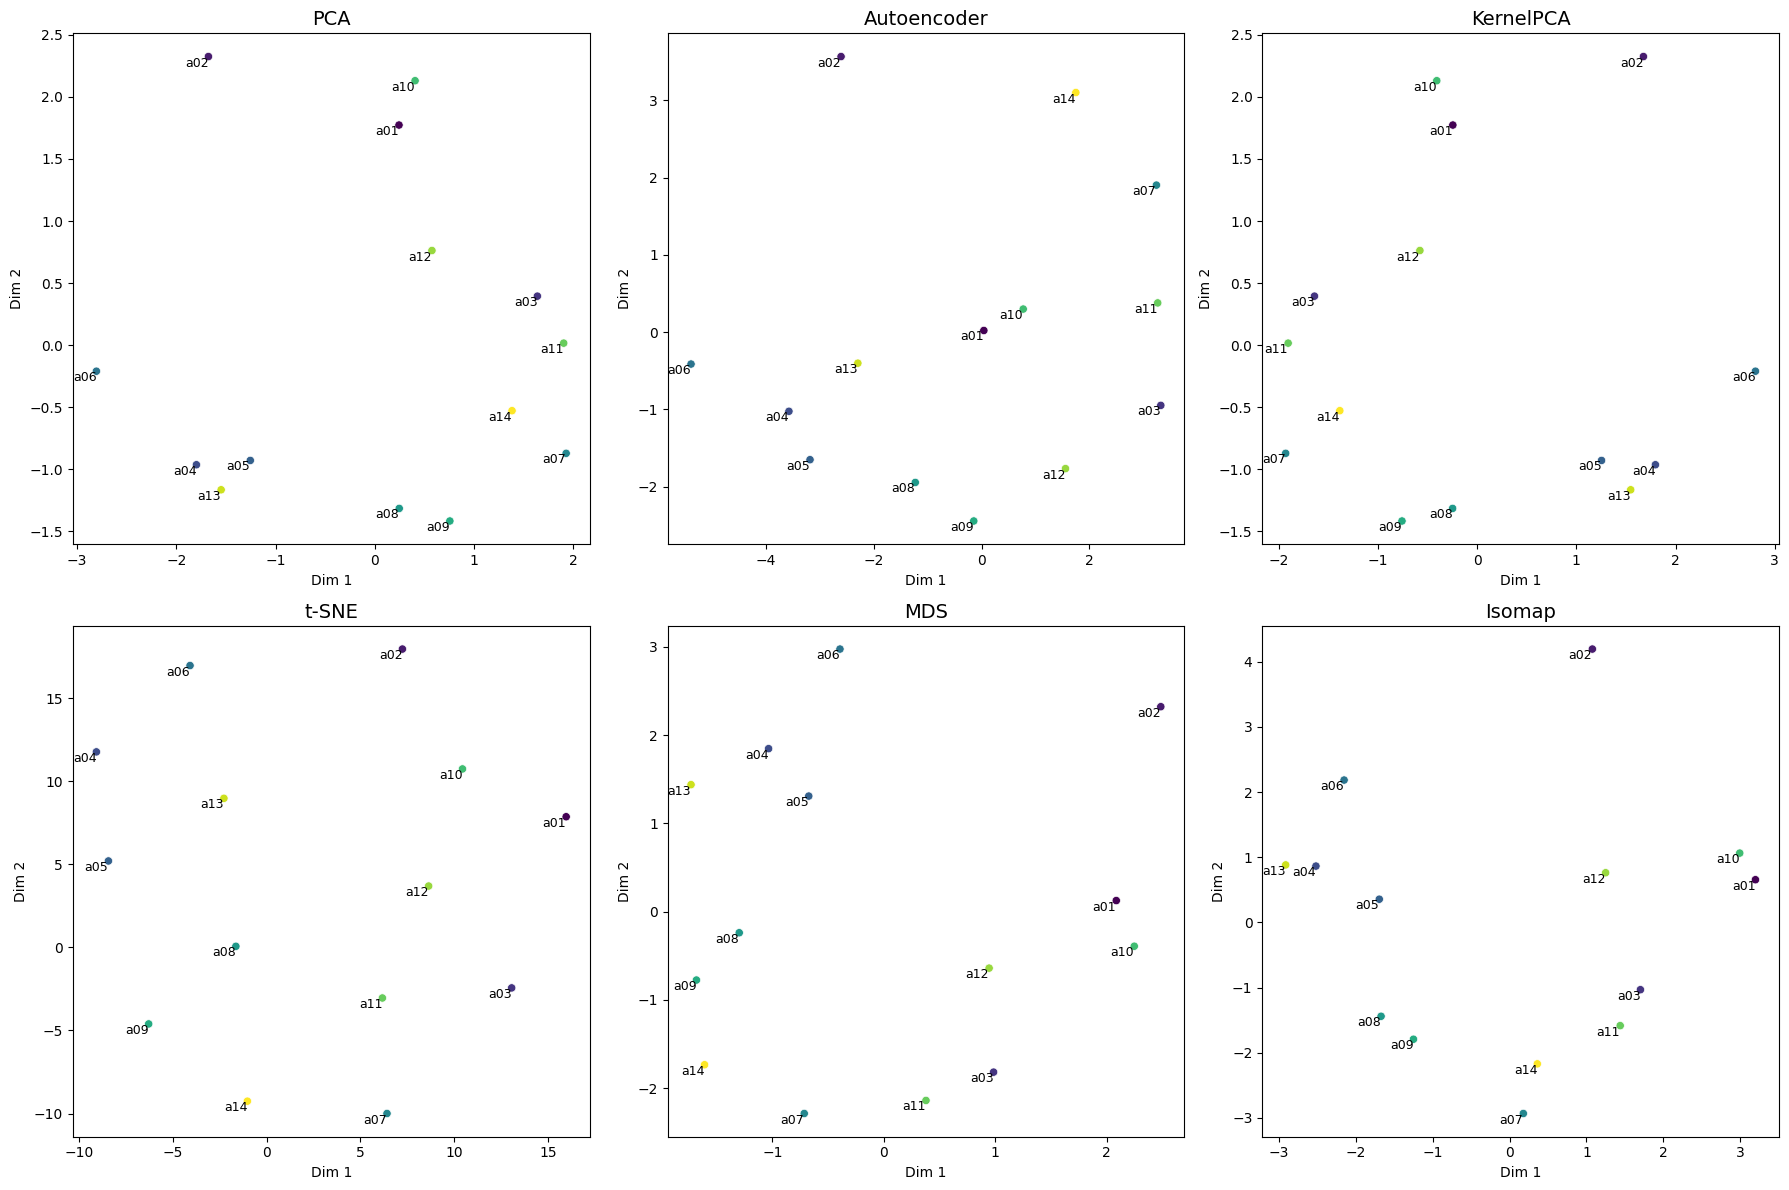

In [5]:
color = np.linspace(0, 1, df_scaled.shape[0])
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df_scaled), index=df.index, columns=["Dim 1", "Dim 2"])

    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    for j in range(df_m.shape[0]):
        axes[i].text(
            df_m.iloc[j, 0],
            df_m.iloc[j, 1],
            str(df_m.index[j]),
            fontsize=9,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
plt.savefig("plots.png")
plt.show()